# Analyze firing rates of LMAN single units

- Compare motif firing rates between different conditions
- Get values from unit_profile table
- Run firing_rates.py to calculate motif firing rates

## Load data from unit_profile table

In [1]:
from database.load import ProjectLoader
from deafening.plot import plot_bar_comparison, plot_per_day_block
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from util import save
from util.draw import remove_right_top
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

save_path = save.make_dir(ProjectLoader().path / 'Analysis', 'Results', add_date=False)

# Load database
db = ProjectLoader().load_db()
# SQL statement
query = """SELECT unit.birdID, unit.taskName, unit.taskSession, 
    unit.baselineFR, unit.motifFRUndir, unit.motifFRDir,  
    cluster.taskSessionDeafening, cluster.taskSessionPostDeafening, cluster.block10days
    FROM unit_profile unit INNER JOIN cluster ON cluster.id = unit.clusterID"""

df = db.to_dataframe(query)
df.dropna(subset=['motifFRUndir'], inplace=True)  # drop out NaNs
df['normFRUndir'] = df['motifFRUndir'] - df['baselineFR']  #  get normalized firing rates by subtracting the baseline fr

## Compare firing rates pre vs. post-deafening

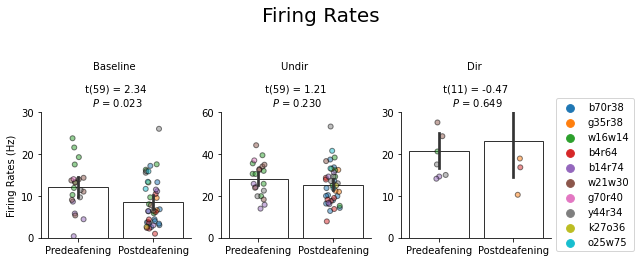

In [2]:
# Parameters
nb_row = 3
nb_col = 3
save_fig = False
fig_ext = '.png'

# Plot the results
fig, ax = plt.subplots(figsize=(9, 4))
plt.suptitle('Firing Rates', y=.9, fontsize=20)

# Baseline FR
ax = plt.subplot2grid((nb_row, nb_col), (1, 0), rowspan=2, colspan=1)
plot_bar_comparison(ax, df['baselineFR'], df['taskName'],
                    hue_var=df['birdID'],
                    title='Baseline', y_label='Firing Rates (Hz)',
                    col_order=("Predeafening", "Postdeafening"),
                    y_lim=[-0.05, 30]
                    )

# Undir
ax = plt.subplot2grid((nb_row, nb_col), (1, 1), rowspan=2, colspan=1)
plot_bar_comparison(ax, df['motifFRUndir'], df['taskName'],
                    hue_var=df['birdID'],
                    title='Undir',
                    col_order=("Predeafening", "Postdeafening"),
                    y_lim=[-0.05, 60]
                    )

# Dir
ax = plt.subplot2grid((nb_row, nb_col), (1, 2), rowspan=2, colspan=1)
plot_bar_comparison(ax, df['motifFRDir'], df['taskName'],
                    hue_var=df['birdID'],
                    title='Dir',
                    col_order=("Predeafening", "Postdeafening"),
                    y_lim=[-0.05, 30],
                    legend_ok=True
                    )
fig.tight_layout()

# Save results
if save_fig:
    save_path = save.make_dir(ProjectLoader().path / 'Analysis', 'Results')
    save.save_fig(fig, save_path, 'Firing Rates', fig_ext=fig_ext)
else:
    plt.show()

## Plot the results across day blocks

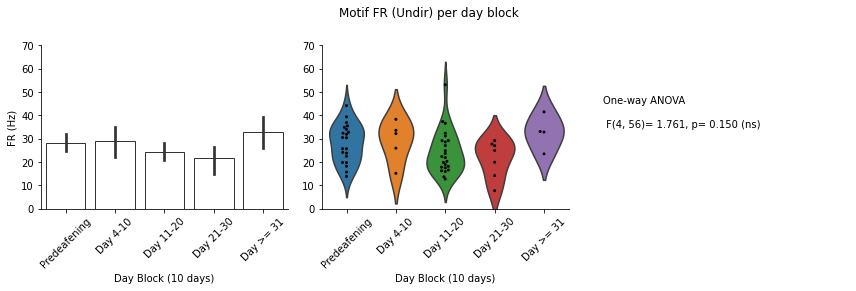

In [3]:
# Plot motif FR per day blocks
plot_per_day_block(df, ind_var_name='block10days', dep_var_name='motifFRUndir',
                   title='Motif FR (Undir) per day block',
                   y_label='FR (Hz)', y_lim=[0, 70],
                   view_folder=True,
                   fig_name='MotifFR_per_day_block',
                   save_fig=False, fig_ext='.png'
                   )

## Combine block 3 & 4

- Combine values from 3 and 4th block into a single block (Day >= 21)

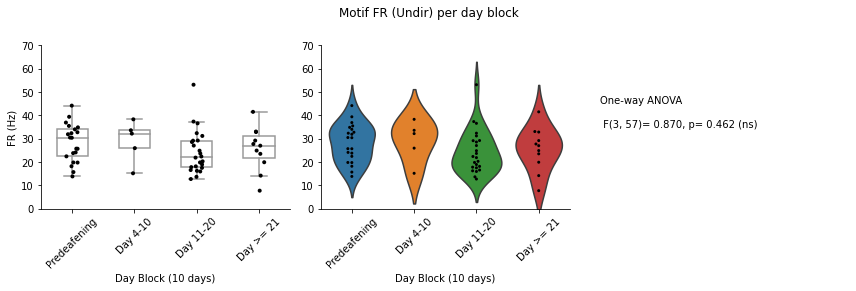

In [4]:
df['block10days'].replace(4, 3, inplace=True) 

# Plot motif FR per day blocks
plot_per_day_block(df, ind_var_name='block10days', dep_var_name='motifFRUndir',
                   title='Motif FR (Undir) per day block',
                   y_label='FR (Hz)', y_lim=[0, 70],
                   plot_type='box',
                   view_folder=True,
                   fig_name='MotifFR_per_day_block', save_folder_name='UnitProfiling',
                   save_fig=False, fig_ext='.png'
                   )

## Compare baseline vs. motif firing rates

In [5]:
def compare_baseline_fr(df, x1, x2,
                        x_lim=None, y_lim=None,
                        y_label=None,
                        title=None,
                        fig_name='Untitled',
                        save_fig=False,
                        fig_ext='.png'
                        ):
    import numpy as np
    from scipy.stats import ttest_rel
    import seaborn as sns
    from util.stats import paired_ttest
    from util.draw import remove_right_top
    
    font_size=10
    """Make paired-comparisons between baseline and motif firing rates"""
    fig, ax = plt.subplots(1, 2, 
                           # dpi=150,
                           figsize=(6, 4), 
                          )
    plt.suptitle(title, y=.98, fontsize=font_size)
    dot_size = 30

    tasks = sorted(df['taskName'].unique(), reverse=True)

    # Plot scatter
    for ind, task in enumerate(tasks):
        df_task = df.query(f"taskName == '{task}'")
        sns.scatterplot(np.zeros(len(df_task[x1])), df_task[x1],
                        s=dot_size, color='k', ax=ax[ind], edgecolor='none')

        sns.scatterplot(np.ones(len(df_task[x2])), df_task[x2],
                        s=dot_size, color='k', ax=ax[ind], edgecolor='none')
        remove_right_top(ax[ind])

        # Plot connecting lines
        for cluster in range(len(df_task[x1])):
            ax[ind].plot([0, 1],
                         [df_task[x1], df_task[x2]],
                         'k-', linewidth=0.5)

        # 2 sample paired t-test
        group1, group2 = df_task[x1], df_task[x2]
        # _, _, msg, sig = two_sample_ttest(group1, group2)
        _, _, msg, sig = paired_ttest(group1, group2)
        ax[ind].set_xlim(x_lim)
        ax[ind].set_xticks([0, 1])
        ax[ind].set_xticklabels(['Baseline', 'Motif FR'])
        ax[ind].set_ylim(y_lim)
        if ind == 0:
            ax[ind].set_title(f"\nPredeafening (n={len(df_task)}) \n\n {msg}", size=font_size)
            ax[ind].set_ylabel(y_label)
        else:
            ax[ind].set_title(f"\nPostdeafening (n={len(df_task)}) \n\n {msg}", size=font_size)
            ax[ind].set_ylabel('')
    plt.tight_layout()

    # Save results
    if save_fig:
        save.save_fig(fig, save_path, fig_name, fig_ext=fig_ext, view_folder=True)
    else:
        plt.show()

In [9]:
# Compare motif firing rates relative to baseline firing rates
compare_baseline_fr(df, 'baselineFR', 'motifFRUndir',
                    x_lim=[-0.1, 1.1], y_lim=[-2, 60],
                    y_label='FR',
                    title='Motif FR (Undir)',
                    fig_name='Baseline vs. Motif FR',
                    save_fig=True,
                    fig_ext='.pdf'
                    )

## Compare normalized firing rates

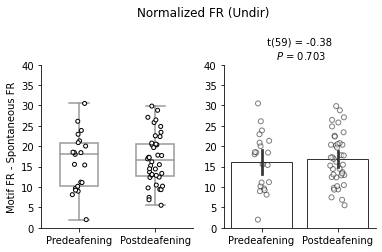

In [7]:
save_fig = False
fig_ext = '.png'

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
plt.suptitle('Normalized FR (Undir)', y=1.15, fontsize=12)

sns.boxplot(x=df['taskName'], y=df['normFRUndir'], 
            ax=axes[0], width=0.5, color='w', 
            order=("Predeafening", "Postdeafening"),
            showfliers=False
           )
sns.stripplot(x=df['taskName'], y=df['normFRUndir'], 
              color='w', edgecolor='k', jitter=0.1, size=4, linewidth=1,
              order=("Predeafening", "Postdeafening"),
             ax=axes[0])
# plt.setp(axes[0].artists, edgecolor = 'k', facecolor='w')
# plt.setp(axes[0].lines, color='k')
remove_right_top(axes[0])
axes[0].set_ylim([0, 40])
axes[0].set_ylabel('Motif FR - Spontaneous FR')
axes[0].set_xlabel('')

plot_bar_comparison(axes[1], df['normFRUndir'], df['taskName'],
                    # hue_var=df['birdID'],
                    # y_label='Norm FR',
                    col_order=("Predeafening", "Postdeafening"),
                    y_lim=[0, 40], legend_ok=True
                    )

# Save results
if save_fig:
    save.save_fig(fig, save_path, 'NormalizedFR(Undir)', fig_ext='.pdf')
else:
    plt.show()

## Firing rates for individual syllables

- read from syllable_pcc table

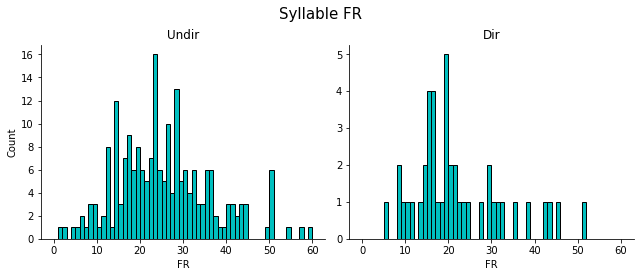

In [8]:
# Compare distributions
# Parameters
save_fig = False
fig_ext = '.png'

def plot_fr_hist(save_fig=True, fig_ext='.png', bin_width=1,
                 hist_col='c',
                 edge_col='black'):

    from math import ceil
    # # SQL statement
    df = db.to_dataframe("SELECT * FROM syllable_pcc")
    df.set_index('syllableID')

    # Plot syllable FR histograms
    fig, ax = plt.subplots(1, 2, figsize=(9, 4))
    # fig.set_dpi(300)
    fig.suptitle('Syllable FR', y=.95, fontsize=15)
    ax[0].set_title('Undir')
    ax[0].hist(df['frUndir'], bins=range(0, ceil(max(df['frUndir'])) + bin_width, bin_width),
               color=hist_col, edgecolor=edge_col)
    ax[0].set_xlabel('FR'), ax[0].set_ylabel('Count')
    remove_right_top(ax[0])

    ax[1].set_title('Dir')
    ax[1].hist(df['frDir'], bins=range(0, ceil(max(df['frUndir'])) + bin_width, bin_width),
               color=hist_col, edgecolor=edge_col)
    ax[1].set_xlabel('FR')
    remove_right_top(ax[1])
    plt.tight_layout()

    # Save figure
    if save_fig:
        save_path = save.make_dir(ProjectLoader().path / 'Analysis', 'Results')
        save.save_fig(fig, save_path, 'syllable_fr_hist', fig_ext=fig_ext)
    else:
        plt.show()

plot_fr_hist(save_fig=save_fig)